In [1690]:
import keras
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense, Bidirectional, Dropout
from keras.layers import Embedding
import keras.backend as K

import numpy as np
import string
import csv
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import random


In [1691]:
url = "./datasets/pre_processed_dataset.csv"
names = ["tweet", "label"]
data = pd.read_csv(url,names=names)
data = data.drop(data.index[0])
data = data.sample(frac = 1)

In [1692]:
X = data['tweet']
y = data['label']

In [1693]:
y[y == 0] = 1

C:\Users\USER\AppData\Local\Temp\ipykernel_11916\4066623601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 0] = 1


In [1694]:
y[y == -1] = 0

C:\Users\USER\AppData\Local\Temp\ipykernel_11916\3153561895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == -1] = 0


In [1695]:
num_classes = 2

# Vectorization

In [1696]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [1697]:
# หาความยาวสูงสุดของ senence ใน tweets
max_length = max([len(word_tokenize(i)) for i in X])

In [1698]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [1699]:
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' %(vocab_size))

Found 2078 unique tokens.


In [1700]:
# integer encode the tweets
x_sequences = tokenizer.texts_to_sequences(X)

In [1701]:
# encode the label
y = keras.utils.to_categorical(y, num_classes)

In [1702]:
X = pad_sequences(x_sequences, maxlen=max_length)

# Split data

In [1703]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [1704]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214, 51), (214, 2), (38, 51), (38, 2))

In [1705]:
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)

In [1706]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((214, 51), (214, 2), (38, 51), (38, 2))

# LSTM

##### set parameter

In [1722]:
epochs=30
batch_size=10

## Create model 1

In [1723]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    CuDNNLSTM(128, return_sequences=True),
    Dropout(0.25),

    CuDNNLSTM(128),
    Dropout(0.25),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes,activation='softmax')
])

In [1724]:
# model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [1725]:
rmsprop = keras.optimizers.RMSprop(lr = .001)

model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

c:\Users\USER\anaconda3\envs\envtf\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [1726]:
model.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_146 (Embedding)   (None, 51, 32)            66496     
                                                                 
 cu_dnnlstm_297 (CuDNNLSTM)  (None, 51, 128)           82944     
                                                                 
 dropout_379 (Dropout)       (None, 51, 128)           0         
                                                                 
 cu_dnnlstm_298 (CuDNNLSTM)  (None, 128)               132096    
                                                                 
 dropout_380 (Dropout)       (None, 128)               0         
                                                                 
 dense_292 (Dense)           (None, 128)               16512     
                                                                 
 dropout_381 (Dropout)       (None, 128)            

In [1727]:
# from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=5, patience=4)

## train model1

In [1728]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/30
22/22 [==============================] - 3s 45ms/step - loss: 0.6997 - accuracy: 0.4720 - val_loss: 0.6936 - val_accuracy: 0.4737
Epoch 2/30
22/22 [==============================] - 0s 17ms/step - loss: 0.6981 - accuracy: 0.4860 - val_loss: 0.6920 - val_accuracy: 0.5263
Epoch 3/30
22/22 [==============================] - 0s 16ms/step - loss: 0.6973 - accuracy: 0.5234 - val_loss: 0.6922 - val_accuracy: 0.5263
Epoch 4/30
22/22 [==============================] - 0s 15ms/step - loss: 0.6931 - accuracy: 0.5234 - val_loss: 0.6976 - val_accuracy: 0.5263
Epoch 5/30
22/22 [==============================] - 0s 15ms/step - loss: 0.6708 - accuracy: 0.6308 - val_loss: 0.6452 - val_accuracy: 0.6842
Epoch 6/30
22/22 [==============================] - 0s 17ms/step - loss: 0.3406 - accuracy: 0.9019 - val_loss: 1.5891 - val_accuracy: 0.5526
Epoch 7/30
22/22 [==============================] - 0s 15ms/step - loss: 0.1633 - accuracy: 0.9393 - val_loss: 0.8596 - val_accuracy: 0.5789
Epoch 8/30
22

In [1729]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 1.7661 - accuracy: 0.7368


[1.7660831212997437, 0.7368420958518982]

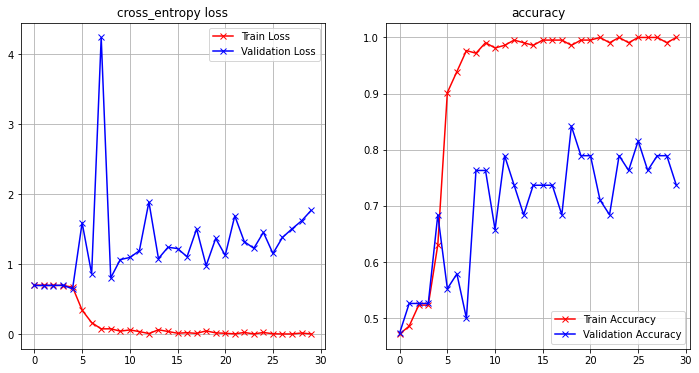

In [1730]:
plot_loss_accuracy(history)

# LSTM biderectional

## Create model 2

In [1731]:
model_2 = Sequential([
    Embedding(vocab_size, 32, input_length=max_length),
    Bidirectional(CuDNNLSTM(128, return_sequences=True)),
    Dropout(0.25),

    Bidirectional(CuDNNLSTM(128)),
    Dropout(0.25),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes,activation='softmax')
])

In [1732]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [1733]:
model_2.summary()

Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_147 (Embedding)   (None, 51, 32)            66496     
                                                                 
 bidirectional_148 (Bidirect  (None, 51, 256)          165888    
 ional)                                                          
                                                                 
 dropout_382 (Dropout)       (None, 51, 256)           0         
                                                                 
 bidirectional_149 (Bidirect  (None, 256)              395264    
 ional)                                                          
                                                                 
 dropout_383 (Dropout)       (None, 256)               0         
                                                                 
 dense_294 (Dense)           (None, 128)            

## train model_2

In [1734]:
history_2 = model_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True,)

Epoch 1/30
22/22 [==============================] - 4s 65ms/step - loss: 0.7039 - accuracy: 0.5421 - val_loss: 0.7248 - val_accuracy: 0.4737
Epoch 2/30
22/22 [==============================] - 1s 26ms/step - loss: 0.7068 - accuracy: 0.5000 - val_loss: 0.6989 - val_accuracy: 0.4737
Epoch 3/30
22/22 [==============================] - 1s 25ms/step - loss: 0.6913 - accuracy: 0.5374 - val_loss: 0.7328 - val_accuracy: 0.5263
Epoch 4/30
22/22 [==============================] - 1s 25ms/step - loss: 0.7420 - accuracy: 0.5981 - val_loss: 0.7621 - val_accuracy: 0.5263
Epoch 5/30
22/22 [==============================] - 1s 25ms/step - loss: 0.3458 - accuracy: 0.8738 - val_loss: 0.6004 - val_accuracy: 0.8158
Epoch 6/30
22/22 [==============================] - 1s 25ms/step - loss: 0.1015 - accuracy: 0.9766 - val_loss: 1.1985 - val_accuracy: 0.6579
Epoch 7/30
22/22 [==============================] - 1s 26ms/step - loss: 0.0880 - accuracy: 0.9720 - val_loss: 0.7291 - val_accuracy: 0.7368
Epoch 8/30
22

In [1735]:
model_2.evaluate(x_test, y_test)

2/2 [==============================] - 0s 10ms/step - loss: 4.8308 - accuracy: 0.7105


[4.830806732177734, 0.7105262875556946]

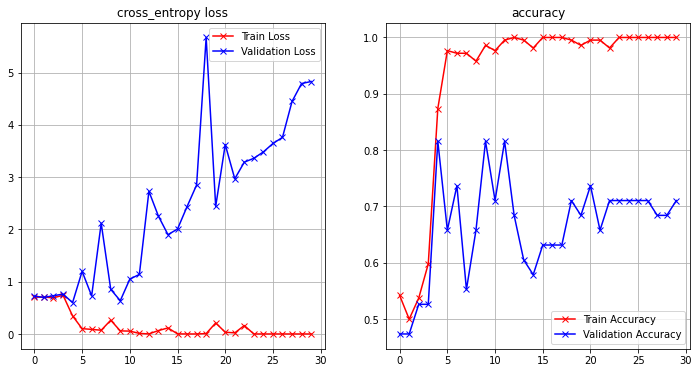

In [1736]:
plot_loss_accuracy(history_2)

# Performance metrics

In [1738]:
pred_model_1 = model.predict(x_test)
pred_model_2 = model_2.predict(x_test)

2/2 [==============================] - 0s 7ms/step


In [1740]:
pred_model_1 = pred_model_1.argmax(1)
pred_model_2 = pred_model_2.argmax(1)

### 1. Recall score

In [1756]:
from sklearn.metrics import recall_score
print('recall score model 1 : ',recall_score(y_test.argmax(1), pred_model_1, average='weighted'))
print('recall score model 2 : ',recall_score(y_test.argmax(1), pred_model_2, average='weighted'))

recall score model 1 :  0.7368421052631579
recall score model 2 :  0.7105263157894737


### 2. F1 score

In [1758]:
from sklearn.metrics import f1_score
print('recall score model 1 : ',f1_score(y_test.argmax(1), pred_model_1, average='macro'))
print('recall score model 2 : ',f1_score(y_test.argmax(1), pred_model_2, average='macro'))

recall score model 1 :  0.7361111111111112
recall score model 2 :  0.7087108013937282
